# Маркетинг <br>

### Описание <br>
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время. <br><br>

#### Цель <br>
Предсказать вероятность покупки в течение 90 дней <br><br>

### Описание данных <br>
#### apparel-purchases <br>
Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук. В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как обработать такие случаи – можете предлагать свои варианты решения.

● client_id идентификатор клиента <br>
● quantity количество единиц товара <br>
● price цена товара <br>
● category_ids идентификаторы категорий <br>
● date дата покупки <br>
● message_id идентификатор сообщения из рассылки <br><br>


#### apparel-messages
Рассылки, которые были отправлены клиентам из таблицы покупок. <br>

● bulk_campaign_id идентификатор рассылки <br>
● client_id идентификатор клиента <br>
● message_id идентификатор сообщения <br>
● event действие с сообщением (отправлено, открыто, покупка…) <br>
● channel канал рассылки <br>
● date дата действия <br>
● created_at дата-время полностью <br>


#### target 
● client_id идентификатор клиента <br>
● target клиент совершил покупку в целевом периоде <br>

Общая база рассылок огромна, поэтому собрали для вас агрегированную по дням
статистику по рассылкам. Если будете создавать на основе этой статистики дополнительные
признаки, обратите внимание, что нельзя суммировать по колонкам nunique, потому что это
уникальные клиенты в пределах дня, у вас нет данных, повторяются ли они в другие дни)


#### full_campaign_daily_event
Агрегация общей базы рассылок по дням и типам событий

● date дата <br>
● bulk_campaign_id идентификатор рассылки <br>
● count_event* общее количество каждого события event <br>
● nunique_event* количество уникальных client_id в каждом событии <br>


#### full_campaign_daily_event_channel
Агрегация по дням с учетом событий и каналов рассылки <br>

● date дата <br>
● bulk_campaign_id идентификатор рассылки <br>
● count_event*_channel* общее количество каждого события по каналам <br>
● nunique_event*_channel* количество уникальных client_id по событиям и каналам

## П.1 Подготовка данных

In [116]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import re
from scipy.stats import mvn
from wordcloud import WordCloud
from scipy import stats as st
from matplotlib import rcParams 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
from phik import resources, report
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ( 
    accuracy_score, 
    precision_score, 
    recall_score,
    roc_auc_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import phik as ph
from phik.report import plot_correlation_matrix
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import ( 
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    FunctionTransformer,
    RobustScaler,
    )

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor


from tqdm.notebook import tqdm
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
import time
import joblib
from xgboost import XGBClassifier
import shap

In [2]:
# Функция для проверки на неявные дубликаты
def nun(data):
    for i in data:
        print('В столбце', i, ':', data[i].nunique(), 'различных значений')

# Функция для рассчета RMSE
def rmse(test, predict):
    return round((mean_squared_error(test, predict))**0.5, 2)

# Функцию, которая визуализировать абсолютное и среднеквадратичное отклонение на графиках
def trgt(test, predict):
    rmse= mean_squared_error(test, predict)
    mae=mean_absolute_error(test, predict)
    plt.figure(figsize=(8, 5))
    pd.Series(predict).hist(bins=20, alpha=0.8)
    pd.Series(test).hist(bins=20, alpha=0.8)
    plt.text(16122,11225,'MAE={:.2f}'.format(mae))
    plt.text(16122,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()
    
    plt.figure(figsize=(8, 8))
    plt.plot(predict,test,'o', alpha=0.5)
    plt.xlim(-5000,25000)
    plt.ylim(-5000,25000)
    plt.plot([-10000,25000],[-10000,25000],'--y', linewidth=2)
    #plt.text(25222,11225,'MAE={:.2f}'.format(mae))
    #plt.text(25222,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

# Функция для определения важности факторов
def importance(model, features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

##### Загрузим данные:
● apparel-purchases <br>
● apparel-messages <br>
● target <br>
● full_campaign_daily_event <br>
● full_campaign_daily_event_channel <br>

#### apparel-purchases

In [3]:
purch = pd.read_csv('/kaggle/input/marketing/apparel-purchases.csv')
purch.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459514e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [4]:
purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [5]:
purch.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [6]:
purch['date'] = pd.to_datetime(purch['date'], format='%Y-%m-%d')

##### Проверим наличие явных дубликатов

In [7]:
purch.duplicated().sum()

73020

In [8]:
purch = purch.drop_duplicates()
purch.duplicated().sum()

0

###### Обнаружено 73 тыс. явных дубликатов. Удаляем их.

##### Проверим наличие неявных дубликатов

In [9]:
nun(purch)

В столбце client_id : 49849 различных значений
В столбце quantity : 16 различных значений
В столбце price : 3642 различных значений
В столбце category_ids : 933 различных значений
В столбце date : 642 различных значений
В столбце message_id : 50204 различных значений


In [10]:
purch['message_id'].value_counts()

message_id
1515915625489095763-6251-6311b13a4cf78     222
1515915625559931867-13598-64cd08c473b82     53
1515915625491842514-12218-644b8318e1247     48
1515915625624308268-7803-636dfea7ca890      47
1515915625490352441-13443-64a52fa882390     46
                                          ... 
1515915625489979428-6283-6316e237a96f1       1
1515915625489417753-6283-6316e24ea223a       1
1515915625488188384-6283-6316e23d4466b       1
1515915625487924223-6283-6316e24139c18       1
1515915626010261344-14648-65cdb6d56c4c8      1
Name: count, Length: 50204, dtype: int64

In [11]:
purch.loc[purch['message_id'] == '1515915625489095763-6251-6311b13a4cf78']

,client_id,quantity,price,category_ids,date,message_id
36203,1515915625502468819,1,699.0,"['2', '18', '258', '441']",2022-09-03,1515915625489095763-6251-6311b13a4cf78
36306,1515915625629865013,1,1908.0,"['4', '28', '104', '429']",2022-09-03,1515915625489095763-6251-6311b13a4cf78
36308,1515915625629865013,1,2045.0,"['4', '28', '218', '653']",2022-09-03,1515915625489095763-6251-6311b13a4cf78
36310,1515915625629865013,1,2045.0,"['4', '28', '104', '429']",2022-09-03,1515915625489095763-6251-6311b13a4cf78
36312,1515915625630428606,1,2799.0,"['4', '28', '104', '429']",2022-09-03,1515915625489095763-6251-6311b13a4cf78
...,...,...,...,...,...,...
172979,1515915625997391318,1,1399.0,"['5562', '5630', '5607', '555']",2023-10-08,1515915625489095763-6251-6311b13a4cf78
173814,1515915625569616141,1,919.0,"['2', '18', '212', '726']",2023-10-15,1515915625489095763-6251-6311b13a4cf78
178086,1515915625475250730,1,1330.0,"['4', '31', '326', '505']",2023-11-11,1515915625489095763-6251-6311b13a4cf78
178087,1515915625475250730,1,1499.0,"['4', '31', '326', '505']",2023-11-11,1515915625489095763-6251-6311b13a4cf78


###### Видим, что несмотря на одинаковые данные в некоторых столбцах - основной периметр данных все равно отличается друг от друга.

In [12]:
purch['category_ids'] = purch['category_ids'].str.replace('[', '').str.replace(']', '').str.replace(" ", '').str.replace("'", '')
purch['main_category'] = purch['category_ids'].str.split(",", expand=True)[0]

In [13]:
purch = purch.drop(columns=['category_ids'])

###### Проверим наличие пропусков

In [14]:
purch.isna().sum()

client_id        0
quantity         0
price            0
date             0
message_id       0
main_category    0
dtype: int64

<Axes: >

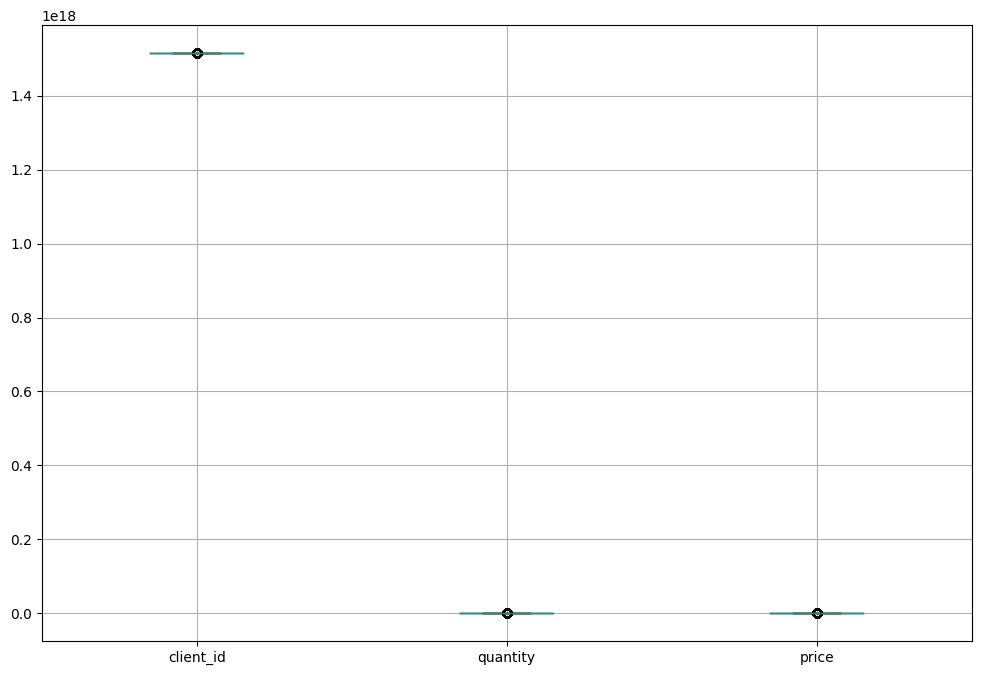

In [15]:
purch.boxplot(figsize=(12,8))

###### Визуализируем quantity и price

In [16]:
purch['quantity'].value_counts()

quantity
1     128352
2        714
3         86
4         12
6          4
10         3
15         3
5          3
25         2
20         2
30         2
13         1
18         1
8          1
9          1
7          1
Name: count, dtype: int64

In [17]:
purch['quantity'].describe()

count    129188.000000
mean          1.009420
std           0.220332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

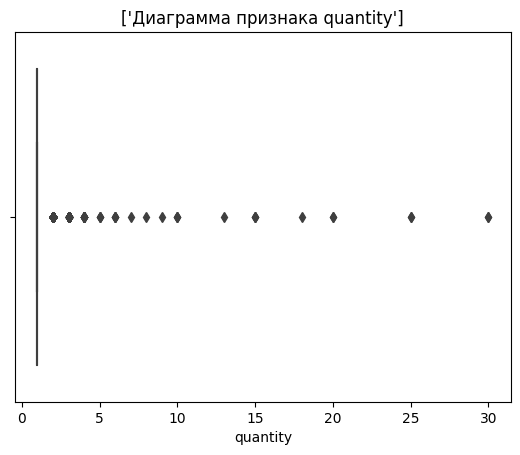

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


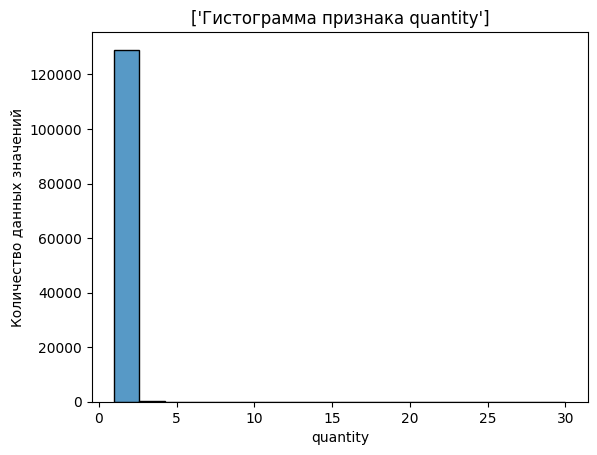

In [18]:
sns.boxplot(data=purch, x='quantity').set(title=['Диаграмма признака ' + 'quantity'])
plt.show()
sns.histplot(purch['quantity']).set(title=['Гистограмма признака ' + 'quantity'], ylabel='Количество данных значений')
plt.show()

In [19]:
purch['price'].value_counts()

price
999.0      7676
1499.0     5972
1999.0     5678
599.0      4259
399.0      3583
           ... 
3048.0        1
2532.0        1
2857.0        1
2482.0        1
13173.0       1
Name: count, Length: 3642, dtype: int64

In [20]:
purch['price'].describe()

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64

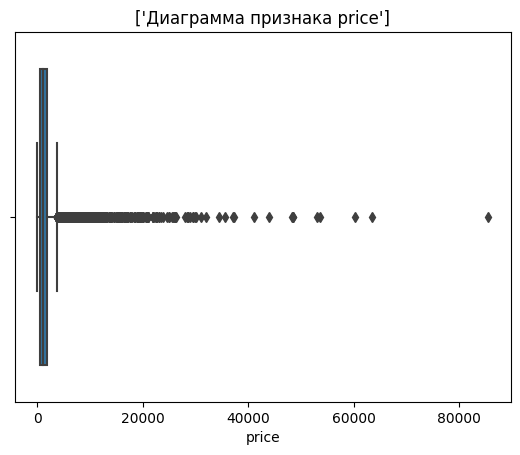

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


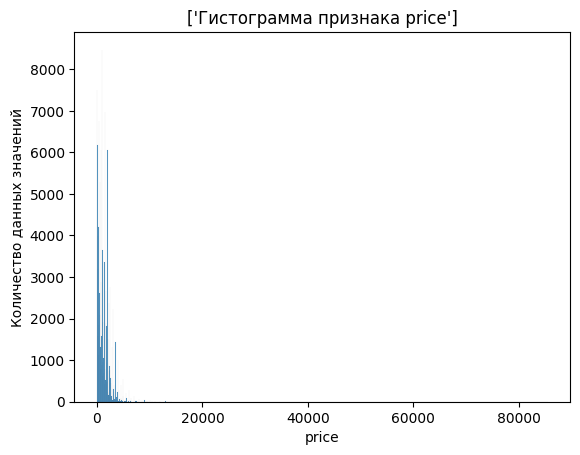

In [21]:
sns.boxplot(data=purch, x='price').set(title=['Диаграмма признака ' + 'price'])
plt.show()
sns.histplot(purch['price']).set(title=['Гистограмма признака ' + 'price'], ylabel='Количество данных значений')
plt.show()

###### Из apparel-purchases удалили явные дубликаты и столбец с категорией товара. Преобразован столбец 'category_ids'. 

##### apparel-messages

In [22]:
mess = pd.read_csv('/kaggle/input/marketing/apparel-messages.csv')
mess.describe()

,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,3.265518e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


In [23]:
mess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [24]:
mess.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [25]:
mess['date'] = pd.to_datetime(mess['date'], format='%Y-%m-%d')
mess['created_at'] = pd.to_datetime(mess['created_at'], format='%Y-%m-%d %H:%M:%S')

##### Проверим наличие явных дубликатов

In [26]:
mess.duplicated().sum()

48610

In [27]:
mess = mess.drop_duplicates()
mess.duplicated().sum()

0

###### Обнаружено 48,6 тыс. явных дубликатов. Удаляем их.

##### Проверим наличие неявных дубликатов

In [28]:
nun(mess)

В столбце bulk_campaign_id : 2709 различных значений
В столбце client_id : 53329 различных значений
В столбце message_id : 9061667 различных значений
В столбце event : 11 различных значений
В столбце channel : 2 различных значений
В столбце date : 638 различных значений
В столбце created_at : 4103539 различных значений


In [29]:
mess['bulk_campaign_id'].unique()

array([ 4439,  2499,  4172, ..., 14655, 14654, 14657])

In [30]:
mess['bulk_campaign_id'].value_counts()

bulk_campaign_id
14272    104060
14276     63362
4679      50621
11760     45745
14081     44067
          ...  
657           1
1391          1
1080          1
548           1
4478          1
Name: count, Length: 2709, dtype: int64

In [31]:
mess['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [32]:
mess['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

In [33]:
mess['client_id'].unique()

array([1515915625626736623, 1515915625490086521, 1515915625553578558, ...,
       1515915625579017480, 1515915626010234726, 1515915625549777338])

In [34]:
mess['client_id'].value_counts()

client_id
1515915625516327994    3088
1515915625625548006    3067
1515915625804998560    2721
1515915625489071904    1845
1515915625489095763    1427
                       ... 
1515915625558767774       1
1515915625577289455       1
1515915625840706531       1
1515915625977549113       1
1515915625500865072       1
Name: count, Length: 53329, dtype: int64

In [35]:
mess['message_id'].unique()

array(['1515915625626736623-4439-6283415ac07ea',
       '1515915625490086521-4439-62834150016dd',
       '1515915625553578558-4439-6283415b36b4f', ...,
       '1515915625490988866-14656-65ce97f929ca4',
       '1515915625617022616-14656-65ce97f9299fe',
       '1515915625491736359-14656-65ce97f92a3fd'], dtype=object)

In [36]:
mess['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

###### Неявных дубликатов не обнаружено

###### Проверим наличие пропусков

In [37]:
mess.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

###### Пропусков в данных не обнаружено.

###### Проверим различем между столбцами "created_at" и 'date'

In [38]:
mess.query('abs((date - created_at).dt.days) > 1')['created_at'].count()

0

###### Различий между столбцами нет, убираем дубль

In [39]:
mess = mess.drop(columns=["created_at"])

<Axes: >

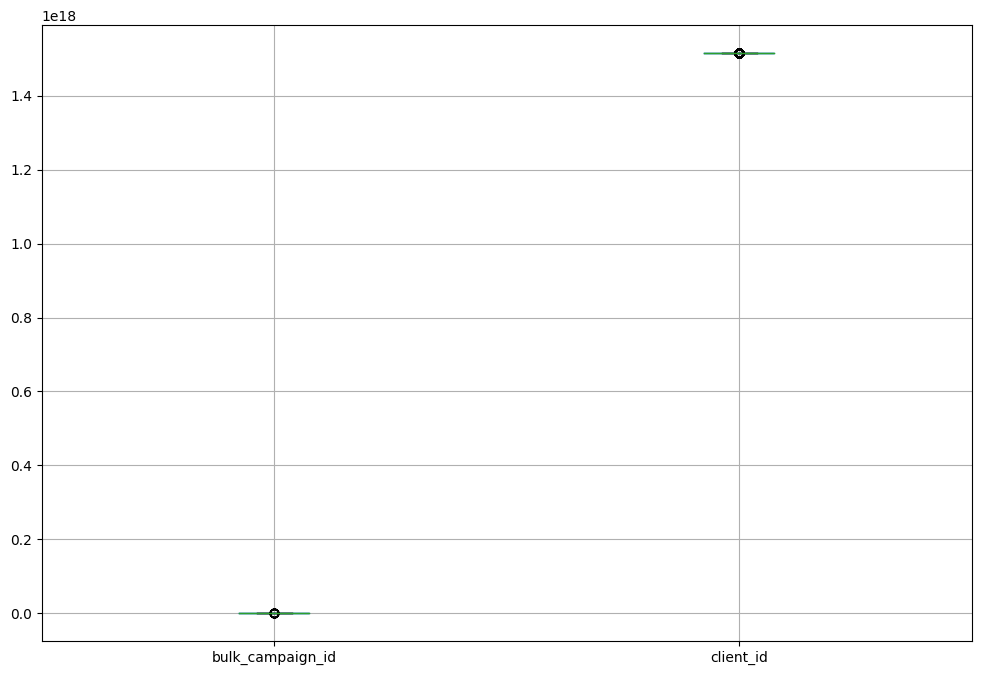

In [40]:
mess.boxplot(figsize=(12,8))

##### Данные параметры детальнее рассматривать нет смысла, так как они отражают уникальные идентификаторы. Выбросы в данных идентификаторах могут означать VIP-сегмент и прочие уникальные группы.

###### Из apparel-messages удалили явные дубликаты и столбец с категорией товара. Преобразован столбец 'category_ids'. 

##### apparel-target_binary

In [41]:
target = pd.read_csv('/kaggle/input/marketing/apparel-target_binary.csv')
target.describe()

,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


In [42]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [43]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [44]:
##### Проверим наличие явных дубликатов

In [45]:
target.duplicated().sum()

0

###### Явных дубликатов не найдено. Проверим наличие неявных дубликатов

In [46]:
target['client_id'].value_counts()

client_id
1515915625468060902    1
1515915625586058988    1
1515915625585957439    1
1515915625585959517    1
1515915625585965079    1
                      ..
1515915625491478211    1
1515915625491478669    1
1515915625491478747    1
1515915625491478978    1
1515915626010443624    1
Name: count, Length: 49849, dtype: int64

In [47]:
target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

###### Проверим наличие пропусков в данных

In [48]:
target.isna().sum()

client_id    0
target       0
dtype: int64

Пропусков нет, дубликатов нет.

##### full_campaign_daily_event

In [49]:
fcde = pd.read_csv('/kaggle/input/marketing/full_campaign_daily_event.csv')
fcde.describe()

,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,...,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,...,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,...,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,...,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000


In [50]:
fcde.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [51]:
fcde.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [52]:
fcde.duplicated().sum()

0

In [53]:
fcde.isna().sum()

date                   0
bulk_campaign_id       0
count_click            0
count_complain         0
count_hard_bounce      0
count_open             0
count_purchase         0
count_send             0
count_soft_bounce      0
count_subscribe        0
count_unsubscribe      0
nunique_click          0
nunique_complain       0
nunique_hard_bounce    0
nunique_open           0
nunique_purchase       0
nunique_send           0
nunique_soft_bounce    0
nunique_subscribe      0
nunique_unsubscribe    0
count_hbq_spam         0
nunique_hbq_spam       0
count_close            0
nunique_close          0
dtype: int64

###### Пропусков нет, дубликатов нет.

##### full_campaign_daily_event_channel

In [54]:
fcdec = pd.read_csv('/kaggle/input/marketing/full_campaign_daily_event_channel.csv')
fcdec.describe()

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


In [55]:
fcdec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

In [56]:
fcdec.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
fcde.duplicated().sum()

0

In [58]:
fcde.isna().sum()

date                   0
bulk_campaign_id       0
count_click            0
count_complain         0
count_hard_bounce      0
count_open             0
count_purchase         0
count_send             0
count_soft_bounce      0
count_subscribe        0
count_unsubscribe      0
nunique_click          0
nunique_complain       0
nunique_hard_bounce    0
nunique_open           0
nunique_purchase       0
nunique_send           0
nunique_soft_bounce    0
nunique_subscribe      0
nunique_unsubscribe    0
count_hbq_spam         0
nunique_hbq_spam       0
count_close            0
nunique_close          0
dtype: int64

Пропусков нет, дубликатов нет.

Вывод: 

##### apparel-purchases
Преобразован тип данных у признаков с датами. Удалены явные дубликаты. Преобразован параметр отвечающий за категории.

##### apparel-messages
Преобразован тип данных у признаков с датами. Удалены явные дубликаты.

##### target
Отклонений не зафиксировано.

##### full_campaign_daily_event
Отклонений не зафиксировано.

##### full_campaign_daily_event_channel
Отклонений не зафиксировано.

## П.2 Исследовательский анализ

#### apparel-purchases

In [59]:
purch.describe()

,client_id,quantity,price,date
count,1.291880e+05,129188.000000,129188.000000,129188
mean,1.515916e+18,1.009420,1264.532766,2023-02-26 07:40:09.771805440
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00
25%,1.515916e+18,1.000000,399.000000,2022-09-09 00:00:00
50%,1.515916e+18,1.000000,999.000000,2023-03-22 00:00:00
75%,1.515916e+18,1.000000,1750.000000,2023-06-28 00:00:00
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00
std,1.452558e+08,0.220332,1375.016339,NaN


In [60]:
purch.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129188 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      129188 non-null  int64         
 1   quantity       129188 non-null  int64         
 2   price          129188 non-null  float64       
 3   date           129188 non-null  datetime64[ns]
 4   message_id     129188 non-null  object        
 5   main_category  129188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.9+ MB


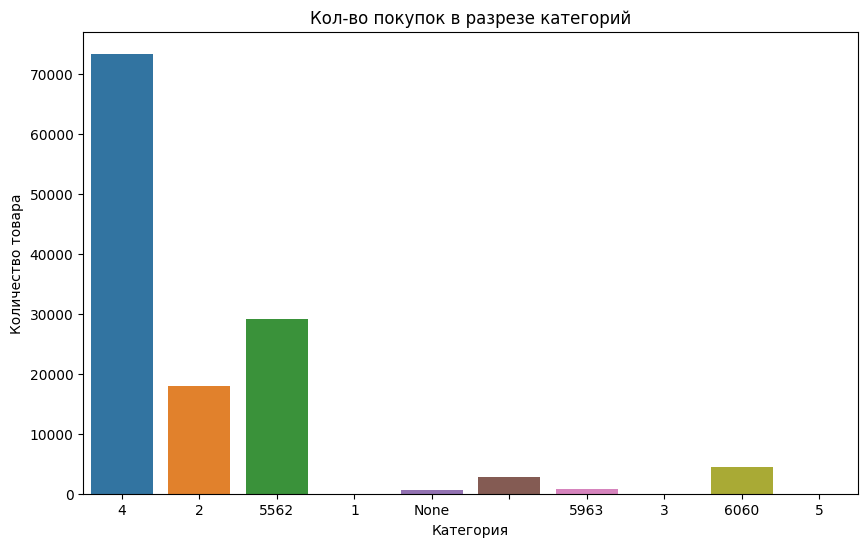

In [61]:
# Кол-во покупок в разрезе категорий
plt.figure(figsize=(10, 6))
sns.countplot(data=purch, x='main_category')
plt.title("Кол-во покупок в разрезе категорий")
plt.xlabel("Категория")
plt.ylabel("Количество товара")
plt.show()

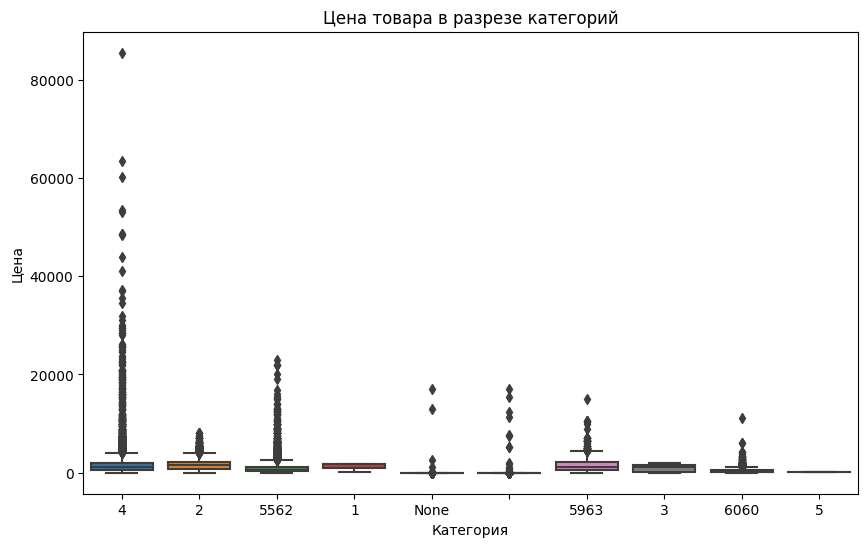

In [62]:
# Цена товара в разрезе категорий
plt.figure(figsize=(10, 6))
sns.boxplot(data=purch, x='main_category', y='price')
plt.title("Цена товара в разрезе категорий")
plt.xlabel("Категория")
plt.ylabel("Цена")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


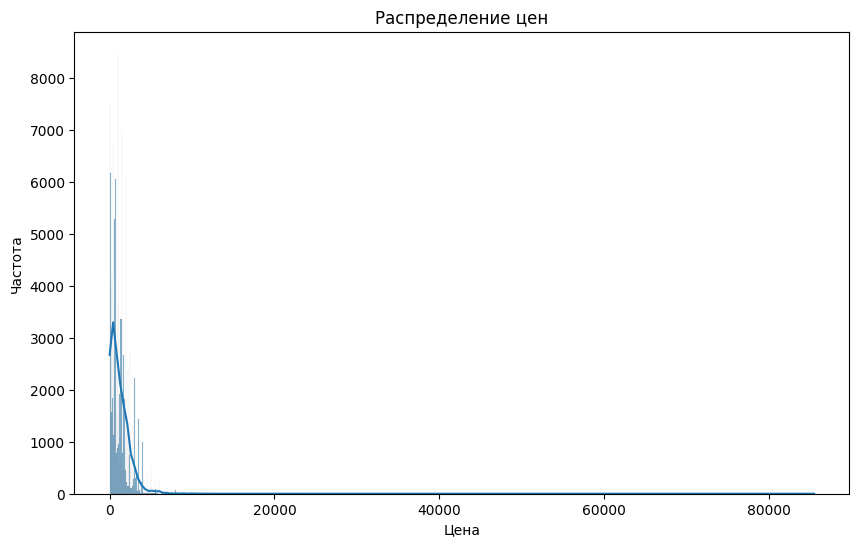

In [63]:
# Наиболее частая цена
plt.figure(figsize=(10, 6))
sns.histplot(purch['price'], kde=True)
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

/tmp/ipykernel_36/2880847161.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=purch, x='quantity', y='price', palette='viridis')


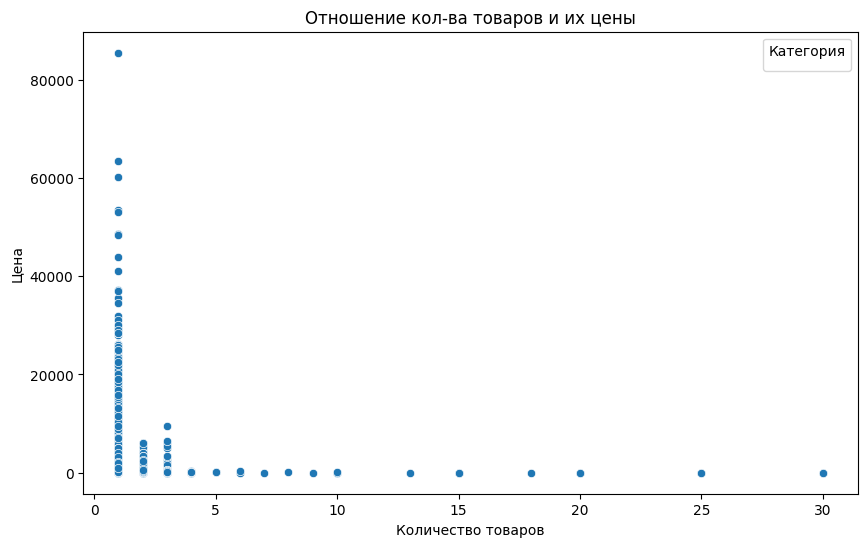

In [64]:
# Отношение кол-ва товаров и их цены
plt.figure(figsize=(10, 6))
sns.scatterplot(data=purch, x='quantity', y='price', palette='viridis')
plt.title("Отношение кол-ва товаров и их цены")
plt.xlabel("Количество товаров")
plt.ylabel("Цена")
plt.legend(title='Категория')
plt.show()

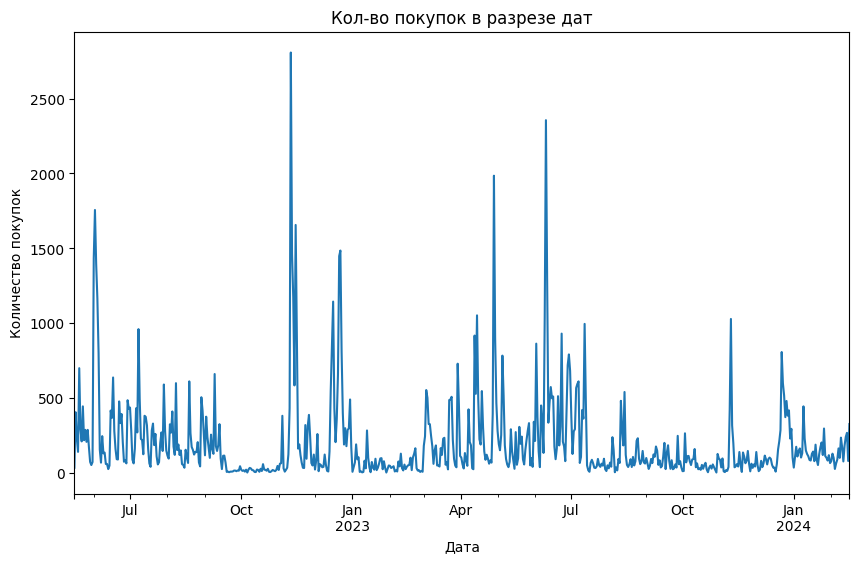

In [65]:
# Кол-во покупок в разрезе дат
purch.groupby('date').size().plot(figsize=(10,6))
plt.title('Кол-во покупок в разрезе дат')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.show()

###### Основные пики клиентских покупок: период с ноября по декабрь (предновогодние праздники) и середина лета (закупки к школам, институтма и сезон гуляний по улице). Предпочитают небольшое кол-во товаров (до 3-ех товаров). И ценой не более 7 тыс. рублей. По кодам товара наибольшей популярностью пользуется: 4, 2, 5562.

#### apparel-messages

In [66]:
mess.describe()

,bulk_campaign_id,client_id,date
count,1.269119e+07,1.269119e+07,12691188
mean,1.159768e+04,1.515916e+18,2023-06-04 17:27:00.569989376
min,5.480000e+02,1.515916e+18,2022-05-19 00:00:00
25%,8.746000e+03,1.515916e+18,2022-12-16 00:00:00
50%,1.351600e+04,1.515916e+18,2023-07-20 00:00:00
75%,1.415800e+04,1.515916e+18,2023-11-21 00:00:00
max,1.465700e+04,1.515916e+18,2024-02-15 00:00:00
std,3.262181e+03,3.250414e+08,NaN


In [67]:
mess.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 677.8+ MB


In [68]:
ev_cnt = mess.event.value_counts()
mess.event.value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

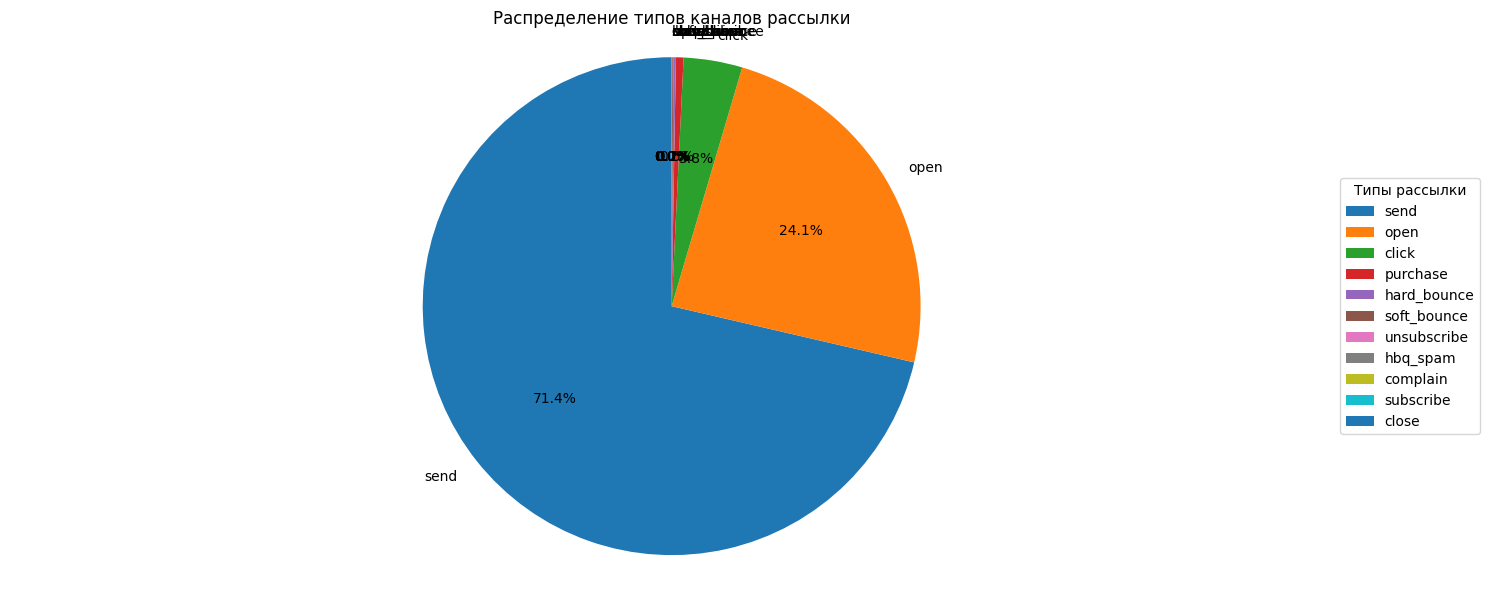

In [69]:
plt.figure(figsize=(15, 6))
plt.pie(ev_cnt.values, labels=ev_cnt.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение типов каналов рассылки')
plt.legend(title="Типы рассылки", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.tight_layout()
plt.show()

In [70]:
ch_cnt = mess['channel'].value_counts()
mess['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

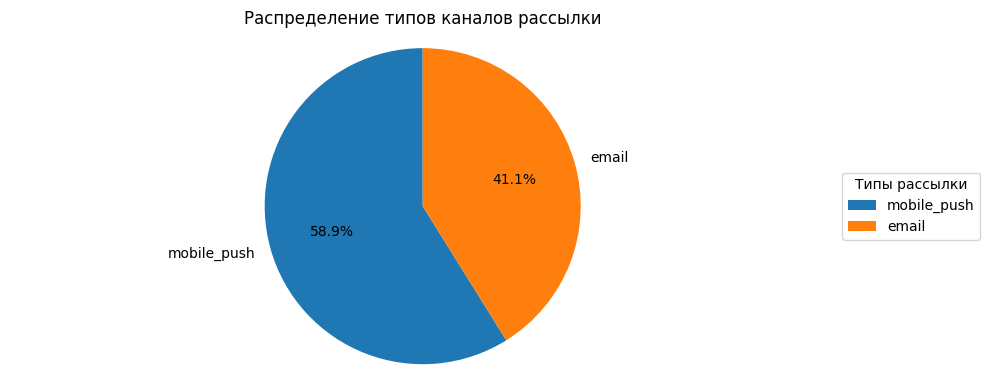

In [71]:
plt.figure(figsize=(10, 4))
plt.pie(ch_cnt.values, labels=ch_cnt.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение типов каналов рассылки')
plt.legend(title="Типы рассылки", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.tight_layout()
plt.show()

Клиенты предпочитают больше пуш-сообщения на мобильный телефон.

Вывод:

Основные пики клиентских покупок: период с ноября по декабрь (предновогодние праздники) и середина лета (закупки к школам, институтма и сезон гуляний по улице). Предпочитают небольшое кол-во товаров (до 3-ех товаров). И ценой не более 7 тыс. рублей. По кодам товара наибольшей популярностью пользуется: 4, 2, 5562. Клиенты предпочитают больше пуш-сообщения на мобильный телефон.

## П.3 Объединим данные

In [72]:
all_table = pd.merge(purch, mess, how='left', on='client_id')
all_table.head()

,client_id,quantity,price,date_x,message_id_x,main_category,bulk_campaign_id,message_id_y,event,channel,date_y
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,4463.0,1515915625468169594-4463-6285e40442c50,send,email,2022-05-19
1,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,4463.0,1515915625468169594-4463-6285e40442c50,open,email,2022-05-19
2,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,4568.0,1515915625468169594-4568-628ddb4b07e71,send,email,2022-05-25
3,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,4568.0,1515915625468169594-4568-628ddb4b07e71,open,email,2022-05-25
4,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,4591.0,1515915625468169594-4591-628f1e827259b,send,email,2022-05-26


In [73]:
nun(all_table)

В столбце client_id : 49849 различных значений
В столбце quantity : 16 различных значений
В столбце price : 3642 различных значений
В столбце date_x : 642 различных значений
В столбце message_id_x : 50204 различных значений
В столбце main_category : 10 различных значений
В столбце bulk_campaign_id : 2706 различных значений
В столбце message_id_y : 7902124 различных значений
В столбце event : 11 различных значений
В столбце channel : 2 различных значений
В столбце date_y : 638 различных значений


In [74]:
mess_a_purch = mess[mess['event'] == 'purchase']['client_id'].unique()
purch_after_mess = purch[purch['client_id'].isin(mess_a_purch)]
purch_non_after_mess = purch[~purch['client_id'].isin(mess_a_purch)]

In [75]:
purch_after_total = len(purch_after_mess)
purch_non_after_total = len(purch_non_after_mess)

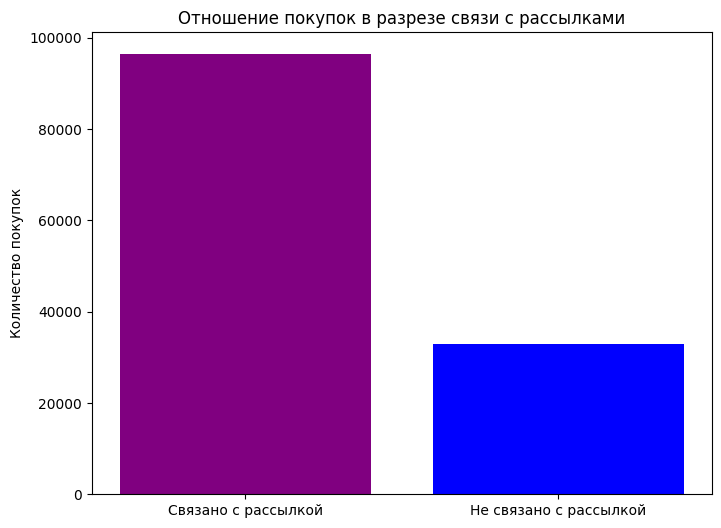

In [76]:
labels = ['Связано с рассылкой', 'Не связано с рассылкой']
values = [purch_after_total, purch_non_after_total]
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['purple', 'blue'])
plt.title('Отношение покупок в разрезе связи с рассылками')
plt.ylabel('Количество покупок')
plt.show()

Вывод:

Объединили два файла в единую таблицу. Вывели отношение покупок от рассылок

## П.4 Новый признак

Добавим признак, указывающий на то, что покупка произошла после события.

In [77]:
events = ['click', 'purchase']
all_table_new = all_table[all_table['event'].isin(events)].copy()

In [78]:
all_table_new['time_purchase'] = all_table_new['date_x'] - all_table_new['date_y']
realy_purch = all_table_new[all_table_new['time_purchase'] > pd.Timedelta(0)].copy()
realy_purch['time_purchase_days'] = realy_purch['time_purchase'].dt.total_seconds() / (3600 * 24)
realy_purch.time_purchase_days.value_counts()

time_purchase_days
1.0      43335
2.0      10407
3.0       5842
7.0       5228
4.0       4932
         ...  
635.0        7
633.0        4
630.0        3
619.0        3
626.0        2
Name: count, Length: 635, dtype: int64

Вывод:

Создали и добавили новый признак, который показывает: произошла покупка после события или нет

## П.5 Корреляционный анализ

In [79]:
final = pd.merge(realy_purch, target, how='left', on='client_id')

In [80]:
final.shape

(619107, 14)

In [81]:
final = final.drop_duplicates()
final.duplicated().sum()

0

In [82]:
final = final.reset_index(drop=True)
final.head()

,client_id,quantity,price,date_x,message_id_x,main_category,bulk_campaign_id,message_id_y,event,channel,date_y,time_purchase,time_purchase_days,target
0,1515915625471021091,1,499.0,2022-05-20,1515915625471021091-4498-628642df6e2e5,5562,4498.0,1515915625471021091-4498-628642df6e2e5,click,mobile_push,2022-05-19,1 days,1.0,0
1,1515915625473844322,1,1999.0,2022-05-20,1515915625473844322-4492-62873ccdde386,4,4463.0,1515915625473844322-4463-6285e4088b6ee,click,email,2022-05-19,1 days,1.0,0
2,1515915625474331476,1,3999.0,2022-05-20,1515915625474331476-4463-6285e40c33c67,2,4463.0,1515915625474331476-4463-6285e40c33c67,click,email,2022-05-19,1 days,1.0,0
3,1515915625478225116,1,299.0,2022-05-20,1515915625478225116-4463-6285e40e6403d,5562,4463.0,1515915625478225116-4463-6285e40e6403d,click,email,2022-05-19,1 days,1.0,0
4,1515915625487228352,1,2399.0,2022-05-20,1515915625487228352-4492-62873cbc4a2b8,4,4439.0,1515915625487228352-4439-62834137b10d8,click,email,2022-05-19,1 days,1.0,0


In [83]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447815 entries, 0 to 447814
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   client_id           447815 non-null  int64          
 1   quantity            447815 non-null  int64          
 2   price               447815 non-null  float64        
 3   date_x              447815 non-null  datetime64[ns] 
 4   message_id_x        447815 non-null  object         
 5   main_category       447815 non-null  object         
 6   bulk_campaign_id    447815 non-null  float64        
 7   message_id_y        447815 non-null  object         
 8   event               447815 non-null  object         
 9   channel             447815 non-null  object         
 10  date_y              447815 non-null  datetime64[ns] 
 11  time_purchase       447815 non-null  timedelta64[ns]
 12  time_purchase_days  447815 non-null  float64        
 13  target        

In [84]:
final['price'] = np.round(final['price']).astype('Int64')
final['time_purchase_days'] = np.round(final['time_purchase_days']).astype('Int64')

In [85]:
interval_columns = ['quantity', 'price','time_purchase_days']

In [86]:
# Вычисление корреляционной матрицы
corr_matrix = final.drop(['client_id', 'message_id_x', 'message_id_y', 'bulk_campaign_id'], axis=1).phik_matrix(interval_cols=interval_columns)

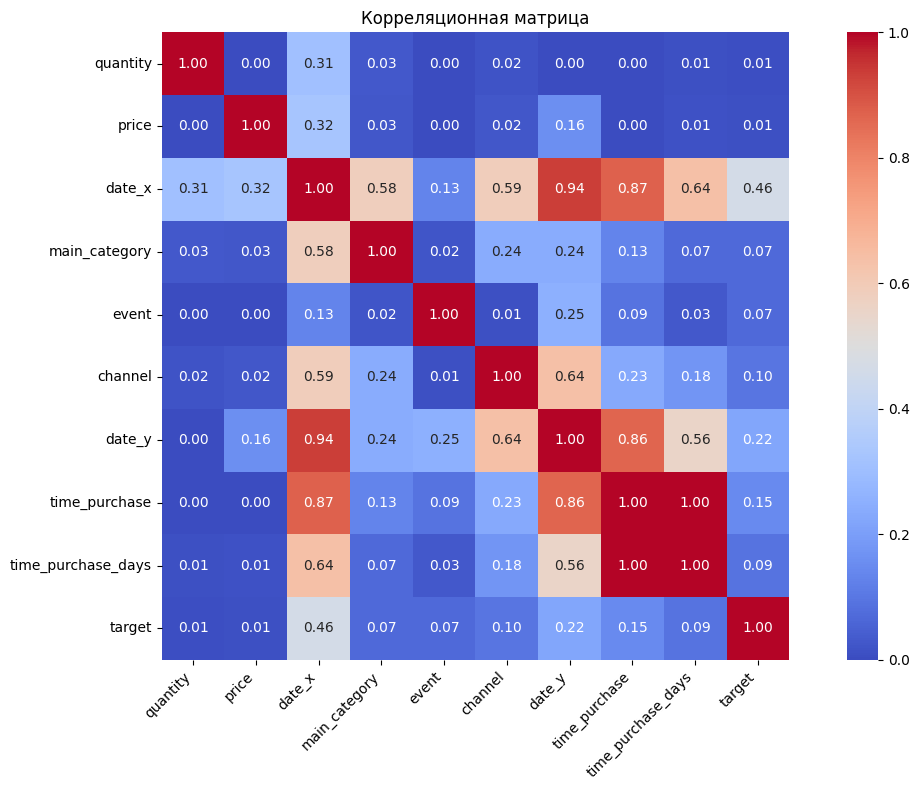

In [87]:
# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True,  
            fmt='.2f',   
            cmap='coolwarm',
            square=True
)
plt.title('Корреляционная матрица')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Значимых корреляций не фиксируется.

## П.6 Обучение модели

Обучим модели:

- Random Forest
- CatBoost
- LightGBM

In [88]:
num = ['quantity', 'price', 'time_purchase_days']
cat = ['main_category', 'event','channel']

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    final.drop(['client_id', 'message_id_x', 'message_id_y', 'bulk_campaign_id', 'target', 'date_x','date_y', 'time_purchase'], axis=1),
    final['target'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=final['target']
)

In [90]:
train_sample=X_train.shape[0]/final.shape[0]
test_sample=X_test.shape[0]/final.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


In [105]:
preprocessor_lr = ColumnTransformer([
    ('num', StandardScaler(), num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
])

preprocessor_boost = ColumnTransformer([
    ('num', 'passthrough', num),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat)
])

oe_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num),
    ('cat', OrdinalEncoder(), cat)
], remainder='passthrough')

In [106]:
models = {
    'RandomForestClassifier': (RandomForestClassifier(), oe_preprocessor),
    'CatBoostClassifier': (CatBoostClassifier(verbose=0, random_state=RANDOM_STATE), preprocessor_boost),
    'LGBMClassifier': (LGBMClassifier(random_state=RANDOM_STATE), preprocessor_boost)
}

param_dist = [
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
        'models__iterations': [50, 100],
        'models__depth': [3, 5, 7],
        'models__learning_rate': [0.01, 0.1, 0.2],
        'models__scale_pos_weight': [1, 5, 10],
        'preprocessor': [preprocessor_boost]
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50],
        'models__max_depth': [3, 5],
        'preprocessor': [preprocessor_boost]
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [10, 15, 20],
        'models__min_samples_split': [10, 50],
        'models__min_samples_leaf': [5, 20],
        'models__max_features': ['sqrt', 'log2'],
        'preprocessor': [oe_preprocessor]
    }
]

In [107]:
pipe_final = Pipeline([
    ('preprocessor', 'passthrough'),  # Временный "заглушка", которую `GridSearchCV` заменит нужным препроцессором
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))  # Начальная модель, которая будет заменена конкретными моделями в `param_dist`
])

In [108]:
with joblib.parallel_backend('threading'):
    search = GridSearchCV(
        pipe_final,
        param_grid=param_dist,
        cv=3,
        verbose=10,
        scoring='roc_auc',
        n_jobs=-1
    )

search.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV 1/3; 2/128] START models=<catboost.core.CatBoostClassifier object at 0x7f0700ae3110>, models__depth=3, models__iterations=50, models__learning_rate=0.01, models__scale_pos_weight=5, preprocessor=ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['quantity', 'price', 'time_purchase_days']),
                                ('cat',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['main_category', 'event', 'channel'])])
[CV 1/3; 2/128] END models=<catboost.core.CatBoostClassifier object at 0x7f0700ae3110>, models__depth=3, models__iterations=50, models__learning_rate=0.01, models__scale_pos_weight=5, preprocessor=ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['quantity', 'price', 'time_purchase_days']),
        

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



[CV 2/3; 99/128] START models=RandomForestClassifier(class_weight='balanced', random_state=42), models__max_depth=15, models__max_features=log2, models__min_samples_leaf=20, models__min_samples_split=10, models__n_estimators=50, preprocessor=ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['quantity', 'price', 'time_purchase_days']),
                                ('cat', OrdinalEncoder(),
                                 ['main_category', 'event', 'channel'])])
[CV 2/3; 99/128] END models=RandomForestClassifier(class_weight='balanced', random_state=42), models__max_depth=15, models__max_features=log2, models__min_samples_leaf=20, models__min_samples_split=10, models__n_estimators=50, preprocessor=ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['quantity', 'price', 'time_purchase_days']),
                         

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor', 'passthrough'),
                                       ('models',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [<catboost.core.CatBoostClassifier object at 0x7e7a09fdf910>],
                          'models__depth': [3, 5, 7],
                          'models__iterations': [50, 100],
                          'models__learning_rate': [0.01, 0.1, 0.2],
                          'models__scale_pos_weight': [1, 5, 10],
                          'p...
                          'models__max_features': ['sqrt', 'log2'],
                          'models__min_samples_leaf': [5, 20],
                          'models__min_samples_split': [10, 50],
                          'models__n_estimators': [50, 100, 200],
                          'preprocessor': [ColumnTransformer(remainder='passthrough',
                                                             transformers=[('num',
                                                                            StandardScaler(),
                                                                            ['quantity',
                                                                             'price',
                                                                             'time_purchase_days']),
                                                                           ('cat',
                                                                            OrdinalEncoder(),
                                                                            ['main_category',
                                                                             'event',
                                                                             'channel'])])]}],
             scoring='roc_auc', verbose=10)

In [109]:
cv_results = pd.DataFrame(search.cv_results_)
results = cv_results[['rank_test_score', 
                              'mean_test_score', 
                              'param_models', 
                              'param_preprocessor']].sort_values(by='rank_test_score')

results.head(10)

,rank_test_score,mean_test_score,param_models,param_preprocessor
118,1,0.778048,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."
106,1,0.778048,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."
121,3,0.777324,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."
109,3,0.777324,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."
120,5,0.777232,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."
108,5,0.777232,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."
105,7,0.776976,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."
117,7,0.776976,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."
119,9,0.775947,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."
107,9,0.775947,RandomForestClassifier(class_weight='balanced'...,"ColumnTransformer(remainder='passthrough',\n ..."


In [112]:
# предсказания на тесте
y_test_pred_proba = search.predict_proba(X_test)[:, 1]

# ROC AUC на тестовой выборке
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"ROC AUC на тесте: {roc_auc:.4f}")

ROC AUC на тесте: 0.7936


## П.7 Важность признаков

  0%|          | 0/1000 [00:00<?, ?it/s]

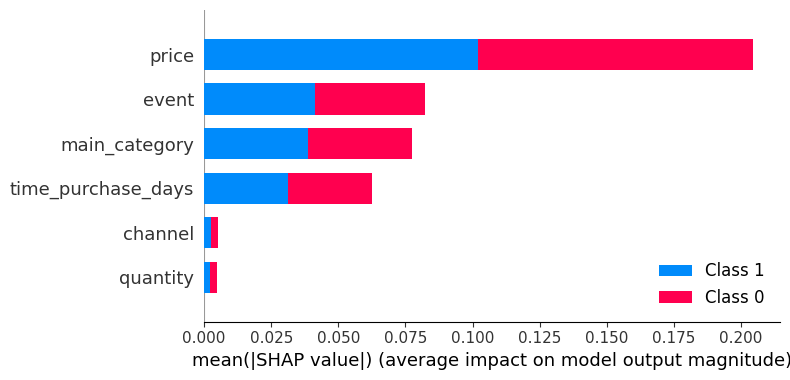

In [119]:
model = search.best_estimator_.named_steps['models']
preprocessor = search.best_estimator_.named_steps['preprocessor']
X_train_transformed = preprocessor.transform(X_train)

# Берём подвыборку
sample_size = min(1000, X_train_transformed.shape[0])
X_train_sampled = shap.utils.sample(X_train_transformed, sample_size)

# TreeExplainer с аппроксимацией
if isinstance(model, (CatBoostClassifier, XGBClassifier, LGBMClassifier)):
    if isinstance(model, XGBClassifier):
        model.get_booster().feature_names = X_train.columns
    elif isinstance(model, LGBMClassifier):
        model.feature_name_ = X_train.columns.tolist()
    
    explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(X_train_sampled, approximate=True, check_additivity=False)

# KernelExplainer с k-means и малым nsamples
else:
    background = shap.kmeans(X_train_transformed, 10)
    explainer = shap.KernelExplainer(model.predict_proba, background)
    shap_values = explainer.shap_values(X_train_sampled, nsamples=100)

# Быстрый рендеринг
shap.summary_plot(
    shap_values, 
    X_train_sampled, 
    plot_type='bar', 
    feature_names=X_train.columns,
    show=False
)

## Вывод

Мы разработали модель для выполнения задачи предсказания вероятности совершения покупки клиентом в течение 90 дней. Для обучения модели мы использовали данные о покупках клиентов и о сообщениях, которые получали клиенты по разным каналам, а также файл с данным, который отражает признак, обозначающий совершение или не совершение покупки в течение 90 дней.

#### П.1 Подготовка данных
##### apparel-purchases
Преобразован тип данных у признаков с датами. Удалены явные дубликаты. Преобразован параметр отвечающий за категории.

##### apparel-messages
Преобразован тип данных у признаков с датами. Удалены явные дубликаты.

##### target
Отклонений не зафиксировано.

##### full_campaign_daily_event
Отклонений не зафиксировано.

##### full_campaign_daily_event_channel
Отклонений не зафиксировано.

#### П.2 Исследовательский анализ
Основные пики клиентских покупок: период с ноября по декабрь (предновогодние праздники) и середина лета (закупки к школам, институтма и сезон гуляний по улице). Предпочитают небольшое кол-во товаров (до 3-ех товаров). И ценой не более 7 тыс. рублей. По кодам товара наибольшей популярностью пользуется: 4, 2, 5562. Клиенты предпочитают больше пуш-сообщения на мобильный телефон.

#### П.3 Объединение данных
Объединили два файла в единую таблицу. Вывели отношение покупок от рассылок.

#### П.4 Создание нового признака
Создали и добавили новый признак, который показывает: произошла покупка после события или нет.

#### П.5 Корреляционный анализ
Добавили файл target в общую таблицу, провели корреляционный анализ. Сильных взаимосвязей не обнаружили.

#### П.6 Обучение модели
Обучили три модели. Наилучшую точность показала: RandomForestClassifier. ROC-AUC на тестовой выборке составил ~0,8

#### П.7 Важность признаков
В рамках анализа важности признаков выявили, что в основном влияте:
- Цена товара;
- Получение рассылки;
- Категория товара.

Отсюда можно сделать вывод, что клиентам важно получать информацию о скидочных предложениях на сезонный товар в любых каналах обслуживания. Стоит уделять большее время летнем переоду, когда клиенты начинают интересоваться подготовкой к школам и вузам, а также предновогоднее время, когда люди готовятся к праздникам.